# Step 1 - Algoritmo di Tag And Probe
Dobbiamo utilizzare un algoritmo meno specializzato e più generalizzato per trovare un'efficienza per la selezione dei muoni prompt.

---
| Caratteristica | Criterio stretto | Criterio largo |
| ------ | ----------- ||
| $\chi^2$   | $0.2<\chi^2<1.8$ | nada |
| $dz$ | $<0.005$ | $<0.009$|
| $dB$  | $<0.003$| $<0,006$ |
| $iso$  | $<4$ | $<9$ |

In [4]:
import ROOT
import particle as pt
import numpy as np

fileDY = ROOT.TFile("../datas/DYJets.root","OPEN")
dytr = fileDY.trees.events

file = ROOT.TFile("../datas/Data.root","OPEN")
tr = file.trees.events

## Test sul DY
Questo è un primo test utilizzato per sviluppare l'algoritmo e vedere se girava. Dopo di questo saremo dovuti passare al tag and probe fatto con uno scan per trovare la migliore efficienza

Warning in <TFile::Append>: Replacing existing TH1: DY_mu_mass_PP (Potential memory leak).


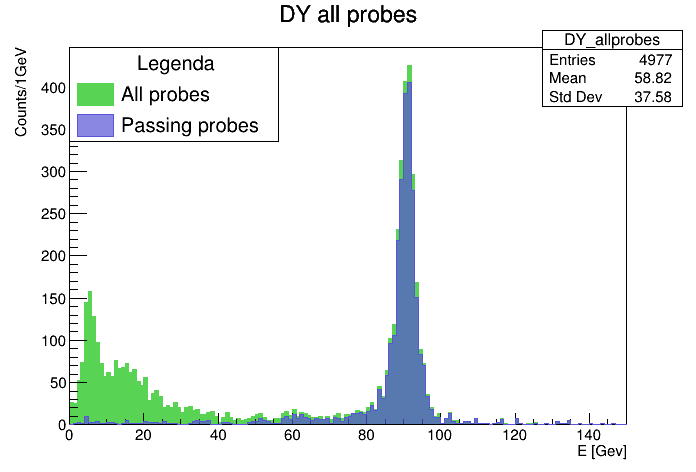

In [5]:
h_passing_probes = ROOT.TH1F("DY_mu_mass_PP","DY Muon mass PP",150,0,150) 
h_failing_probes = ROOT.TH1F("DY_mu_mass_PP","DY Muon mass PP",150,0,150) 
h_all_probes = ROOT.TH1F("DY_allprobes","DY all probes",150,0,150) 
c=ROOT.TCanvas()

for i in range(dytr.GetEntries()):
    dytr.GetEntry(i)
    if(dytr.muontracks_size>1):
        muons = pt.get_collection(dytr, "muontracks")
        for mi in range(len(muons)):
            if(dytr.muontracks_chi2[mi]<1.8 and dytr.muontracks_chi2[mi]>0.2 and dytr.muontracks_dz[mi]<0.005 and dytr.muontracks_dB[mi]<0.003 and dytr.muontracks_isoDeposits[mi]<4):
                p4t=muons[mi].p4
                for mj in range(len(muons)):
                    if(mj != mi):
                        p4ap=muons[mj].p4
                        s_all = (p4t+p4ap).M()
                        h_all_probes.Fill(s_all)
                        if(dytr.muontracks_dz[mj]<0.009 and dytr.muontracks_dB[mj]<0.006 and dytr.muontracks_isoDeposits[mj]<9):
                            p4pp=muons[mj].p4
                            s_pass = (p4t+p4pp).M()
                            h_passing_probes.Fill(s_pass)
                        else:
                            p4fp=muons[mj].p4
                            s_fail = (p4t+p4fp).M()
                            h_failing_probes.Fill(s_fail)
c.Draw()

h_all_probes.SetLineColor(8)
h_all_probes.SetFillColorAlpha(8,1)
h_all_probes.GetXaxis().SetTitle("E [Gev]")
h_all_probes.GetYaxis().SetTitle("Counts/1GeV")
h_all_probes.Draw()

h_passing_probes.SetLineColor(9)
h_passing_probes.SetFillColorAlpha(9,0.7)
h_passing_probes.Draw("SAME")

leg = ROOT.TLegend(0.1,0.7,0.4,0.9) #0.4,0.7,0.6,0.9
leg.SetHeader("Legenda", "C")                         
leg.AddEntry(h_all_probes, "All probes","f")            
leg.AddEntry(h_passing_probes, "Passing probes","f")
leg.Draw()

 FCN=567.723 FROM MIGRAD    STATUS=CONVERGED     245 CALLS         246 TOTAL
                     EDM=5.47356e-07    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   2.0 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           9.06865e+01   5.75291e-02   7.66737e-04   8.41612e-03
   2  p1           3.17086e+00   7.64546e-02   5.65330e-04  -3.31546e-03
   3  p2           2.75900e+03   5.78460e+01   4.20257e-01   3.06429e-07
   4  p3           1.77624e+01   6.14952e-01  -1.34780e-03   1.69825e-03
   5  p4           2.30915e+03   6.00090e+01   3.26531e-01  -7.19191e-06
 FCN=578.023 FROM MIGRAD    STATUS=CONVERGED     215 CALLS         216 TOTAL
                     EDM=6.61161e-10    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           9

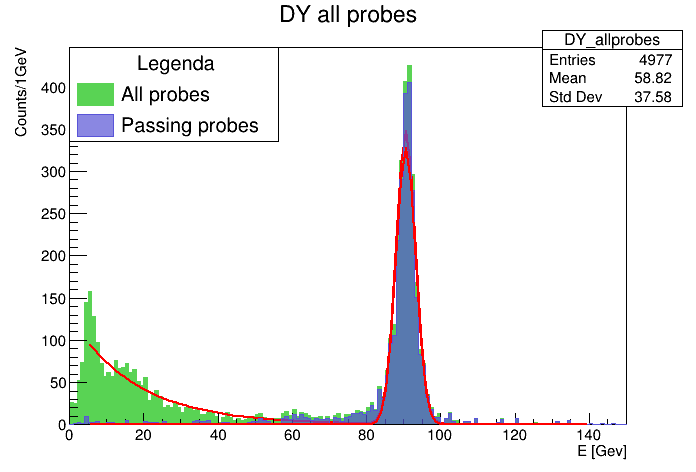

In [6]:
pp = ROOT.TF1("gauss", "[2]*1/([1]*TMath::Sqrt(2*TMath::Pi()))*exp(-((x-[0])*(x-[0]))/(TMath::Sqrt(2)*[1]*[1]))", 5,140)
ap = ROOT.TF1("exp+gauss", "[4]/[3]*TMath::Exp(-x/[3]) + [2]*1/([1]*TMath::Sqrt(2*TMath::Pi()))*exp(-((x-[0])*(x-[0]))/(TMath::Sqrt(2)*[1]*[1]))", 5, 140)

pp.SetParameters(50,10,50)
ap.SetParameters(90,10,10,500,100)

h_all_probes.Fit(ap, "SR")
h_passing_probes.Fit(pp, "SR")

c.Draw()

### Stima efficienza
A questo punto quel che ci resta da fare è definire le funzioni di segnale e fondo, ottenute dal fit, utilizzare poi gli integrali di quelle per capire quale percentuale di muoni passing in realtà è background.
Fidandomi del modello potrò dire che l'integrale dell'esponenziale è il numero di probes (totali) di background, l'integrale della gaussiana è invece il numero di eventi di segnale.
In teoria ciò non dovrebbe avere bias e mi permette di valutare la signal efficiency e la background efficiency

In [4]:
bkg=ROOT.TF1("Background exp","[1]/[0]*TMath::Exp(-x/[0])",5,140)
sig=ROOT.TF1("Signal Gauss","[2]*1/([1]*TMath::Sqrt(2*TMath::Pi()))*exp(-((x-[0])*(x-[0]))/(TMath::Sqrt(2)*[1]*[1]))", 5,140)

sig.SetParameters(90.68, 3.17, 2759)
bkg.SetParameters(17.7,2309)

Non capisco, in questo modo sto calcolando la percentuale dei passing che è realmente segnale. Ma in questo modo però non sto facendo una cosa sostanzialmente diversa da quella di prima? Prima io calcolavo l'efficienza della selezione dei muoni col metodo tag&probe come $$\epsilon = \frac{passingprobes}{allprobes}$$Questo mi diceva quanti muoni passing avevo rispetto ai totali. Ora stiamo valutando la qualità dei passing.
Probabilmente ora mi conviene continuare per questa strada, so dire di tutti i passing che ce ne piace solo circa l'87% (per quanto riguarda i non passing non sono sicuro)

---
Mi scrivo alcuni conti qui per averli sotto mano
$$n_{tot}=n_s+n_b $$
$$n_p=n_{ps}+n_{pb} $$
Per stimare i $n_p$ abbiamo usato $$r_s=\frac{n_p}{n_s} \implies n_{ps}=n_pr_s $$
$$\epsilon_s=\frac{n_{ps}}{n_s} \qquad ; \qquad \epsilon_b = \frac{n_{pb}}{n_b}$$

In [5]:
n_b = bkg.Integral(0,150)   #questo stima n_b
n_s = sig.Integral(0,150)   #questo stima n_s
n_t = ap.Integral(0,150)    #stima di signal+bg

print("n_s:",int(n_s), "\nn_b:", int(n_b),"\nn_tot:",int(n_t)) #questi valori servno per le efficienze

n_p=pp.Integral(5,140)
print("n_pass:",int(n_p))

n_s: 2320 
n_b: 2308 
n_tot: 4628
n_pass: 2171


In [6]:
r_s = n_p/n_s #rapporto fra pass e signal, che % di pass è signal
#r_b = n_p/n_b

n_ps = n_p * r_s
e_s = n_ps/n_s *100

n_pb = n_p - n_ps
e_b = n_pb/n_b *100

print("Signal efficiency:",int(e_s),"\nBackground Efficiency:",int(e_b))#ciò ci dice quanto dei passing è segnale e quanto è fondo

Signal efficiency: 87 
Background Efficiency: 6


## Efficiency Scan
Utilizzo lo stesso metodo per effettuare uno scan dei tagli e trovare le migliori efficienze. Tutto ciò va poi applicato al dataset Data.root

In [8]:
ea = []
e_max = 0
c1=ROOT.TCanvas()
h_epsilon = ROOT.TH1F("efficiency", "efficiency", 100, 0, 100)
for dzc in np.arange(0.007, 0.015 , 0.001):
    print("Sono al dcz = ", dzc)
    for dBc in np.arange(0.006 , 0.010 , 0.001):
        for isoc in np.arange(4, 10, 1):
            h_pass = ROOT.TH1F("DY_mu_mass_PP","DY Muon mass PP",150,0,150)
            h_all = ROOT.TH1F("DY_allprobes","DY all probes",150,0,150) 
            for i in range(dytr.GetEntries()): #inizio ciclo che crea istogramma con la scelta di parametri
                dytr.GetEntry(i)
                if(dytr.muontracks_size>1):
                    muons = pt.get_collection(dytr, "muontracks")
                    for mi in range(len(muons)):
                        if(dytr.muontracks_chi2[mi]<1.8 and dytr.muontracks_chi2[mi]>0.2 and dytr.muontracks_dz[mi]<0.005 and dytr.muontracks_dB[mi]<0.003 and dytr.muontracks_isoDeposits[mi]<4):
                            p4t=muons[mi].p4               #Quadrimpulso muone tag
                            for mj in range(len(muons)):
                                if(mj != mi):              #Qui prendo tutti i probes
                                    p4ap = muons[mj].p4
                                    s_all = (p4t+p4ap).M()
                                    h_all.Fill(s_all)
                                    
                                    if(dytr.muontracks_dz[mj]<dzc and dytr.muontracks_dB[mj]<dBc and dytr.muontracks_isoDeposits[mj]<isoc):
                                        p4pp = muons[mj].p4
                                        s_pass = (p4t+p4pp).M()
                                        h_pass.Fill(s_pass)
            
            pp = ROOT.TF1("gauss", "[2]*1/([1]*TMath::Sqrt(2*TMath::Pi()))*exp(-((x-[0])*(x-[0]))/(TMath::Sqrt(2)*[1]*[1]))", 5,140)
            ap = ROOT.TF1("exp+gauss", "[4]/[3]*TMath::Exp(-x/[3]) + [2]*1/([1]*TMath::Sqrt(2*TMath::Pi()))*exp(-((x-[0])*(x-[0]))/(TMath::Sqrt(2)*[1]*[1]))", 5, 140)
            pp.SetParameters(50,10,50)
            ap.SetParameters(90,10,10,500,100)
            h_all.Fit(ap, "SR")
            h_pass.Fit(pp,"SR")
            n_p=pp.Integral(5,140)

            bkg=ROOT.TF1("Background gauss","[1]/[0]*TMath::Exp(-x/[0])",5,140)
            bkg.SetParameters(ap.GetParameter(3),ap.GetParameter(4))
            n_b = bkg.Integral(5,140)
            
            sig=ROOT.TF1("Signal Gauss","[2]*1/([1]*TMath::Sqrt(2*TMath::Pi()))*exp(-((x-[0])*(x-[0]))/(TMath::Sqrt(2)*[1]*[1]))", 5,140)
            sig.SetParameters(ap.GetParameter(0),ap.GetParameter(1),ap.GetParameter(2))
            n_s=sig.Integral(5,140)

            ei, ebi =pt.eff(n_s,n_b,n_p)
            ea.append(ei)
            if(ei>=max(ea)): 
                params=[dzc,dBc,isoc, ebi] #lista che contiene i migliori parametri

Sono al dcz =  0.007
Sono al dcz =  0.008
Sono al dcz =  0.009000000000000001
Sono al dcz =  0.01
Sono al dcz =  0.011
Sono al dcz =  0.012
Sono al dcz =  0.013000000000000001
Sono al dcz =  0.014
 FCN=567.723 FROM MIGRAD    STATUS=CONVERGED     245 CALLS         246 TOTAL
                     EDM=5.47356e-07    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   2.0 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           9.06865e+01   5.75291e-02   7.66737e-04   8.41612e-03
   2  p1           3.17086e+00   7.64546e-02   5.65330e-04  -3.31546e-03
   3  p2           2.75900e+03   5.78460e+01   4.20257e-01   3.06429e-07
   4  p3           1.77624e+01   6.14952e-01  -1.34780e-03   1.69825e-03
   5  p4           2.30915e+03   6.00090e+01   3.26531e-01  -7.19191e-06
 FCN=515.19 FROM MIGRAD    STATUS=CONVERGED     136 CALLS         137 TOTAL
                     EDM=2.14445e-10    STRATEGY

Warning in <TFile::Append>: Replacing existing TH1: efficiency (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: DY_mu_mass_PP (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: DY_allprobes (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: DY_mu_mass_PP (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: DY_allprobes (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: DY_mu_mass_PP (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: DY_allprobes (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: DY_mu_mass_PP (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: DY_allprobes (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: DY_mu_mass_PP (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: DY_allprobes (Potential memory leak).
Warning

Warning in <TFile::Append>: Replacing existing TH1: efficiency (Potential memory leak).


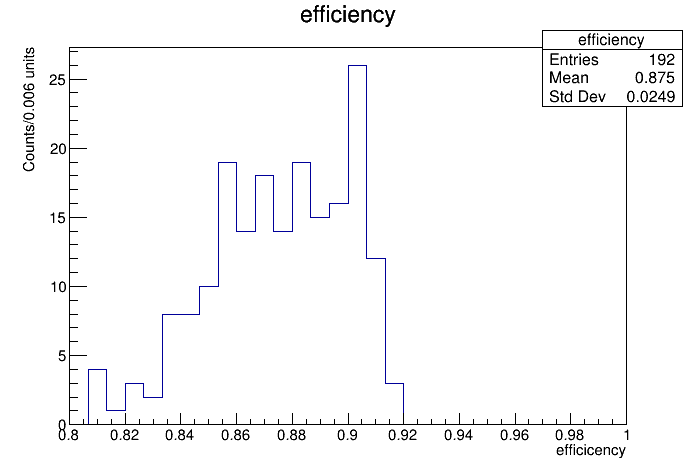

In [9]:
cc = ROOT.TCanvas()
cc.Draw()
ee=[]
h_e = ROOT.TH1F("efficiency", "efficiency", 30, 0.8, 1)
for i in range(len(ea)):
    h_e.Fill(ea[i])
h_e.GetXaxis().SetTitle("efficicency")
h_e.GetYaxis().SetTitle("Counts/0.006 units")
h_e.Draw()
h_e.Draw()

In [16]:
print("Max efficiency:",max(ea),"\nbackgroun efficiency:", params[3],"\n---------------------------------------\ndz at cut:",params[0],"\ndB at cut:",params[1],"\nisoDeposits at cut:",params[2])

Max efficiency: 0.9136520075854073 
backgroun efficiency: 0.05621046874092246 
----------------------------------
dz at cut: 0.014 
dB at cut: 0.007 
isoDeposits at cut: 9


## Dataset Data.root
Facciamo un efficiency scan e poi speriamo in gesù

In [ ]:
ea = []
e_max = 0
#params[]
c2=ROOT.TCanvas()
h_epsilon = ROOT.TH1F("efficiency", "efficiency", 100, 0, 100)
for dzc in np.arange(0.007, 0.015 , 0.001):
    print("sono a dcz = ", dzc)
    for dBc in np.arange(0.006 , 0.010 , 0.001):
        for isoc in np.arange(4, 10, 1):

            h_pass = ROOT.TH1F("mu_mass_PP"," Muon mass PP",150,0,150)
            h_all = ROOT.TH1F("allprobes","All probes",150,0,150) 

            for i in range(tr.GetEntries()): #inizio ciclo che crea istogramma con la scelta di parametri
                tr.GetEntry(i)
                if(tr.muontracks_size>1):
                    muons = pt.get_collection(tr, "muontracks")
                    for mi in range(len(muons)):
                        if(tr.muontracks_chi2[mi]<1.8 and tr.muontracks_chi2[mi]>0.2 and tr.muontracks_dz[mi]<0.005 and tr.muontracks_dB[mi]<0.003 and tr.muontracks_isoDeposits[mi]<4):
                            p4t=muons[mi].p4
                            for mj in range(len(muons)):
                                if(mj != mi):
                                    p4ap = muons[mj].p4
                                    s_all = (p4t+p4ap).M()
                                    h_all.Fill(s_all)
                                    
                                    if(tr.muontracks_dz[mj]<dzc and tr.muontracks_dB[mj]<dBc and tr.muontracks_isoDeposits[mj]<isoc):
                                        p4pp = muons[mj].p4
                                        s_pass = (p4t+p4pp).M()
                                        h_pass.Fill(s_pass)
            
            pp = ROOT.TF1("gauss", "[2]*1/([1]*TMath::Sqrt(2*TMath::Pi()))*exp(-((x-[0])*(x-[0]))/(TMath::Sqrt(2)*[1]*[1]))", 5,140)
            ap = ROOT.TF1("exp+gauss", "[4]/[3]*TMath::Exp(-x/[3]) + [2]*1/([1]*TMath::Sqrt(2*TMath::Pi()))*exp(-((x-[0])*(x-[0]))/(TMath::Sqrt(2)*[1]*[1]))", 5, 140)
            pp.SetParameters(50,10,50)
            ap.SetParameters(90,10,10,500,100)
            h_all.Fit(ap, "SR")
            h_pass.Fit(pp,"SR")
            n_p=pp.Integral(5,140)

            bkg=ROOT.TF1("Background gauss","[1]/[0]*TMath::Exp(-x/[0])",5,140)
            bkg.SetParameters(ap.GetParameter(3),ap.GetParameter(4))
            n_b = bkg.Integral(5,140)
            
            sig=ROOT.TF1("Signal Gauss","[2]*1/([1]*TMath::Sqrt(2*TMath::Pi()))*exp(-((x-[0])*(x-[0]))/(TMath::Sqrt(2)*[1]*[1]))", 5,140)
            sig.SetParameters(ap.GetParameter(0),ap.GetParameter(1),ap.GetParameter(2))
            n_s=sig.Integral(5,140)

            ei,eb=pt.eff(n_s,n_b,n_p)
            ea.append(ei)
            if(ei>=max(ea)): 
                params=[dzc,dBc,isoc,eb]
print("Max efficiency:",max(ea),"\ndz at cut:",params[0],"\ndB at cut:",params[1],"\nisoDeposits at cut:",params[2])

In [ ]:
print("Max efficiency:",max(ea),"\ndz at cut:",params[0],"\ndB at cut:",params[1],"\nisoDeposits at cut:",params[2], )

In [ ]:
cc = ROOT.TCanvas()
cc.Draw()
ee=[]
h_e = ROOT.TH1F("efficiency", "efficiency", 50, 0.75, 1)
for i in range(len(ea)):
    h_e.Fill(ea[i])
h_e.Draw()